In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
import plotly.express as px

sns.set(rc={'figure.figsize':(20,7.27)})

In [2]:
#reading exists data
df = pd.read_csv('datasets/usd-tjs.csv', index_col=0)

#format date and rate of currency
df.index = pd.to_datetime(df.index)
df["Price"] = pd.to_numeric(df["Price"], downcast="float")

In [3]:
#drop zero days when NBT doesn't set rate of currency
df = df[df.Price != 0]

In [4]:
#function that return graph
def graph_date(df):
    plt.ylabel('Rate of USD-TJS')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    
    return plt.plot(df)

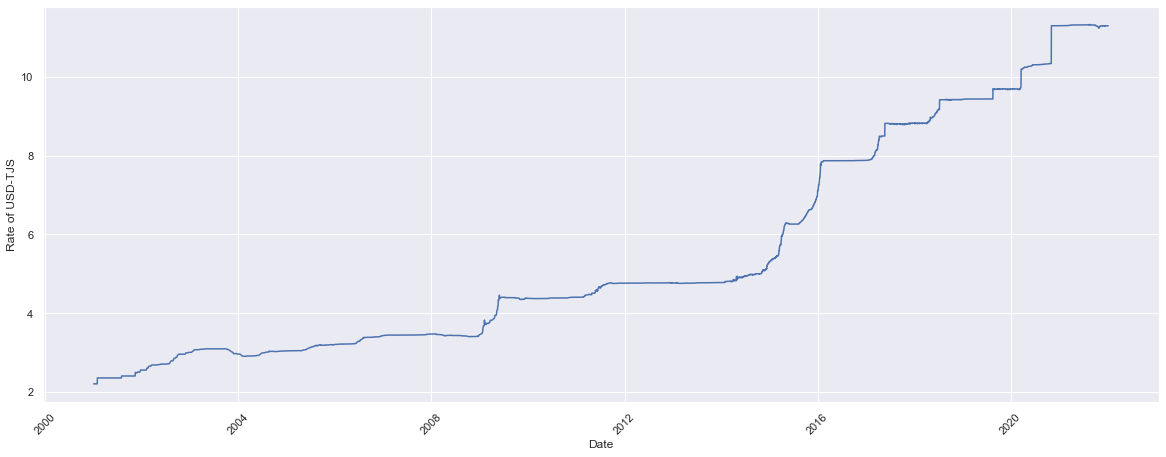

In [5]:
graph_date(df)

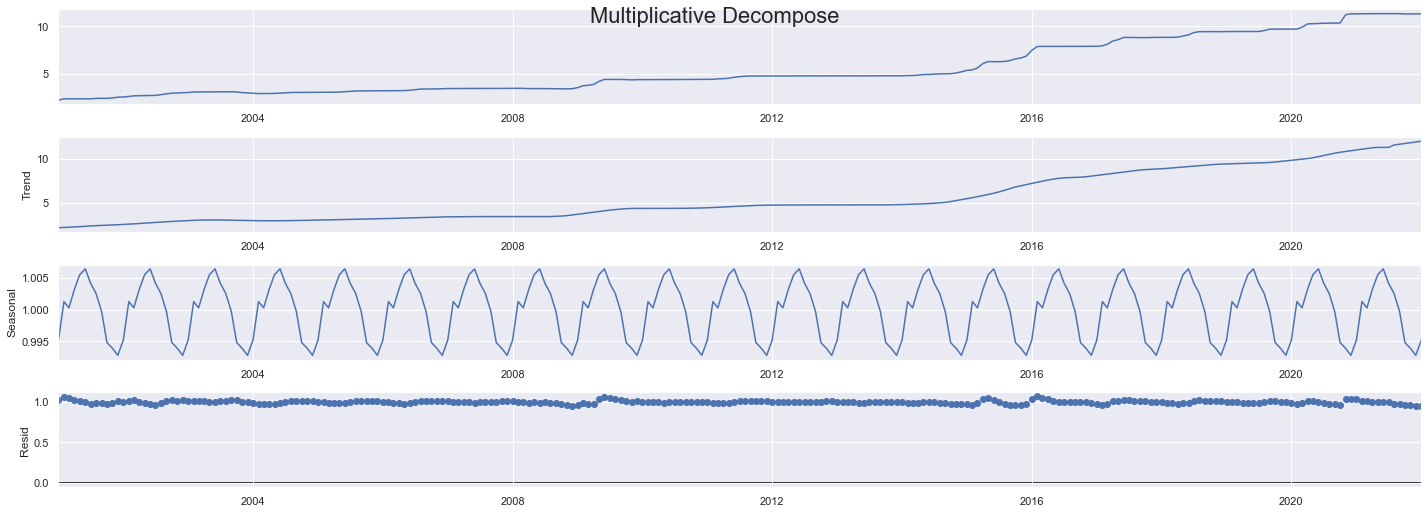

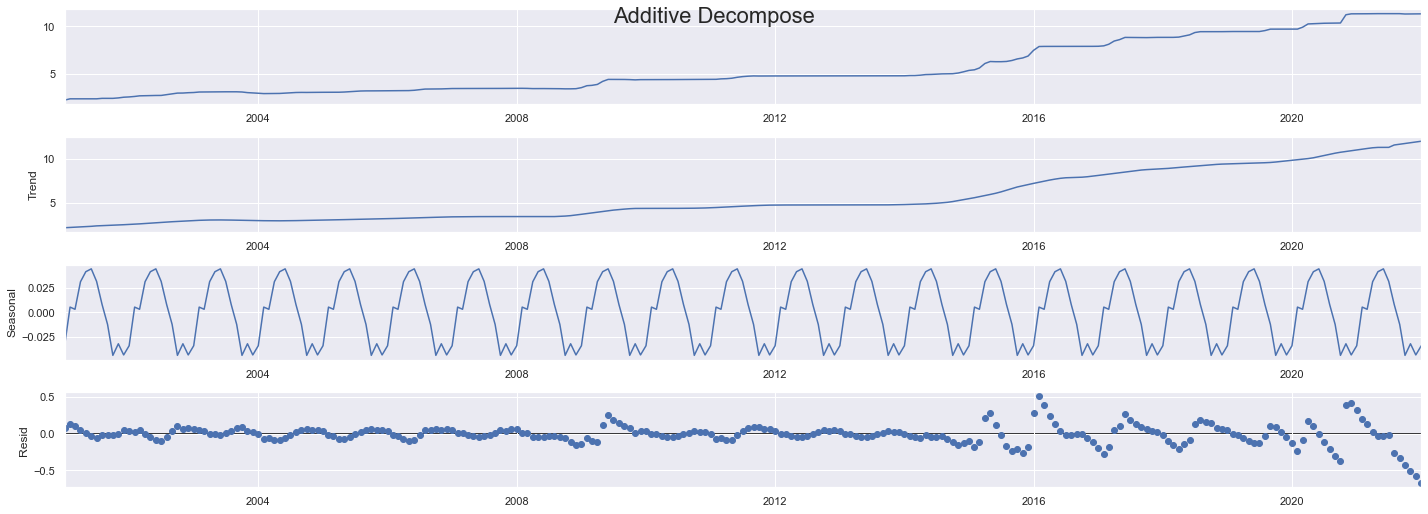

In [6]:
df_month = df.resample("MS").mean()
# Multiplicative Decomposition
result_mul = seasonal_decompose(df_month, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df_month, model='additive', extrapolate_trend='freq')

# Plot
#plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [7]:
# Spliting data into test and train datasets
size = int(len(df_month)*0.8)
train, test = df_month[0:size], df_month[size: len(df_month)]

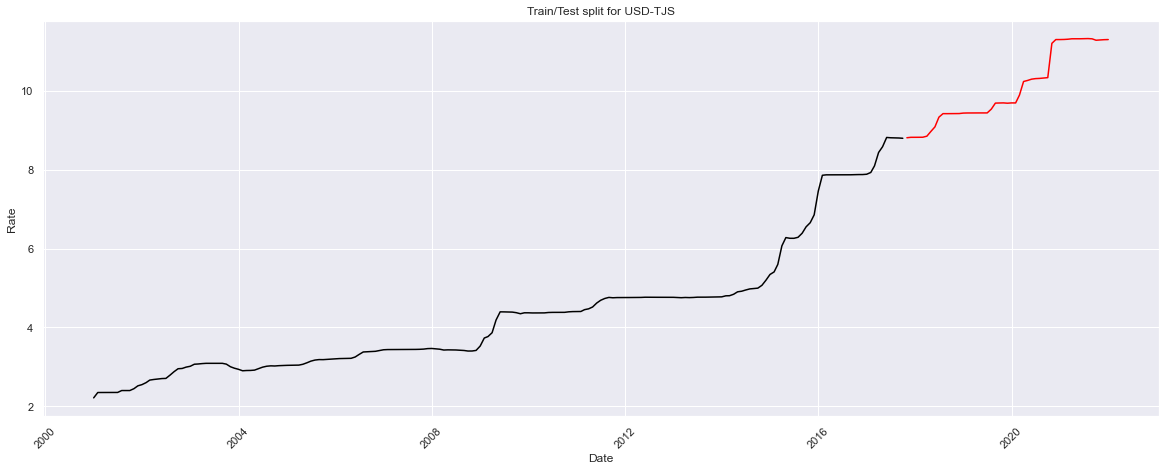

In [8]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Rate')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for USD-TJS")
plt.show()

### Holt-Winters model

In [9]:
# If our data is trending and has seasonality we can use Holt-Winters ExponentialSmooting method
# If we use use_boxcox=True, trend='add', seasonal='add' we will get RMSE 0.36
# but I think model down is better describe
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hwmodel=ExponentialSmoothing (
    train,
    trend='mul', seasonal='mul', 
    seasonal_periods=12
).fit()

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [10]:
first_predict = hwmodel.forecast(len(test))

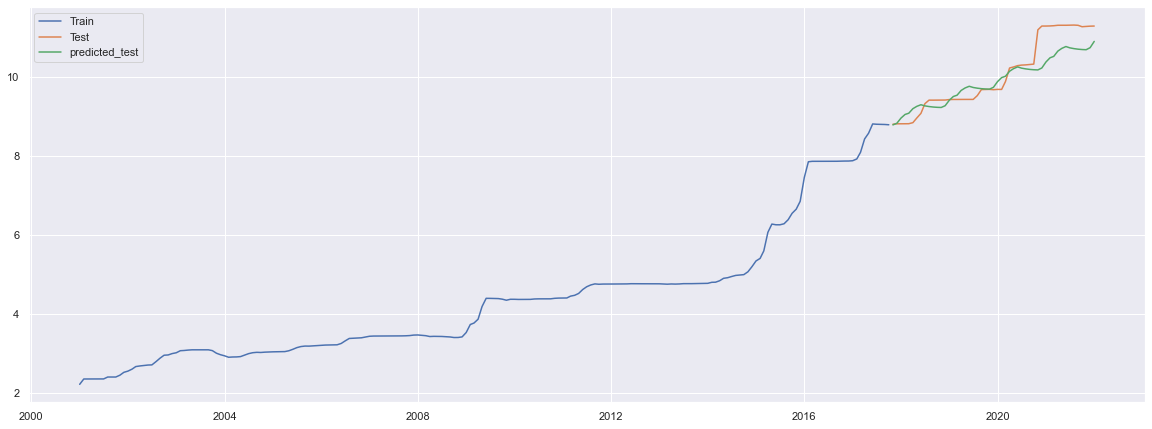

In [11]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(first_predict, label='predicted_test')
plt.legend(loc='best')

In [12]:
# Calculating how our model actually predicting good
# Is the error of predicted model within one standard error away from the mean
print('RMSE of between predicted model and test: ', round(np.sqrt(mean_squared_error(test, first_predict)),2))
print('MAPE of between predicted model and test: ', round(mean_absolute_percentage_error(test, first_predict),2))
print(f'Mean: {df_month.Price.mean()} \nStandard deviation: {np.sqrt(df_month.Price.var())}')

RMSE of between predicted model and test:  0.41
MAPE of between predicted model and test:  0.03
Mean: 5.495157241821289 
Standard deviation: 2.754563093185425


### Final model
The database we used, included data of rates from 2002-01-01 - 2022-01-01 (monthly)<br>
At the bottom, we well fit out model in all data and try predict next four month<br>
And then we will compare with actual rate of currency

In [13]:
df_month_ = df_month[:-1]
full_hwmodel = ExponentialSmoothing (
    df_month_, trend='mul',
    seasonal='mul', seasonal_periods=12,
).fit()

In [14]:
test_predict = full_hwmodel.forecast(4)

In [15]:
new_test = pd.read_csv('datasets/after_2022-01-01_data.csv', index_col=0)
new_test.index = pd.to_datetime(new_test.index)
new_test["Price"] = pd.to_numeric(new_test["Price"], downcast="float")

new_test_month = new_test.resample("MS").mean()

pd.DataFrame({'Price': new_test_month['Price'],'Predicted':test_predict})

,Price,Predicted
2022-01-01,11.300000,11.387478
2022-02-01,11.300000,11.466660
2022-03-01,12.542581,11.544082
2022-04-01,12.615000,11.696275


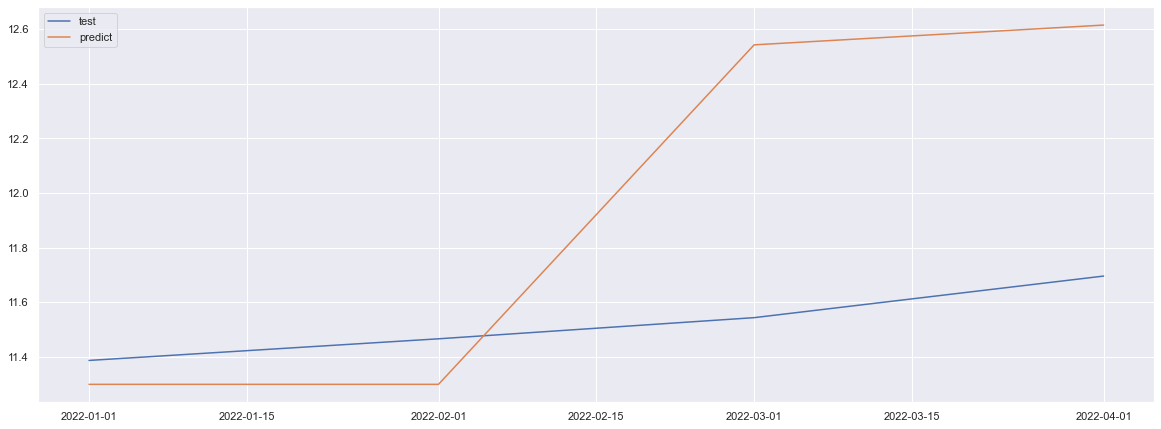

In [16]:

plt.plot(test_predict, label='test')
plt.plot(new_test_month,  label='predict')
plt.legend(loc='best')

In [17]:
# Calculating how out model actually predicting good
# Is the error of predicted model within one standard error away from the mean
print('RMSE of between predicted model and test: ', round(np.sqrt(mean_squared_error(new_test_month, test_predict)),2))
print('MAPE of between predicted model and test: ', round(mean_absolute_percentage_error(new_test_month, test_predict),2))
print(f'Mean: {new_test_month.Price.mean()} \nStandard deviation: {np.sqrt(new_test_month.Price.var())}')

RMSE of between predicted model and test:  0.68
MAPE of between predicted model and test:  0.04
Mean: 11.939395904541016 
Standard deviation: 0.7389014959335327


Overall our model predicted for the next 4 month with RMSE 0.68